# Fipster Python Example Analysis
Here we'll do a straightforward analysis of the provided example data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Custom libraries
import Fipster as fip

# Set this to 'qt' (or a different backend) to get floating figures
%matplotlib inline

We start with loading the data into the FIP_signal object and having a quick look at the recording.

Loading: ../raw_data/example_1.mat
Loading: ../raw_data/example_1_logAI.csv
Sampling interval is: 5.0ms
...resampled
 
RECORDING NOTES: These notes are saved after recording.
 


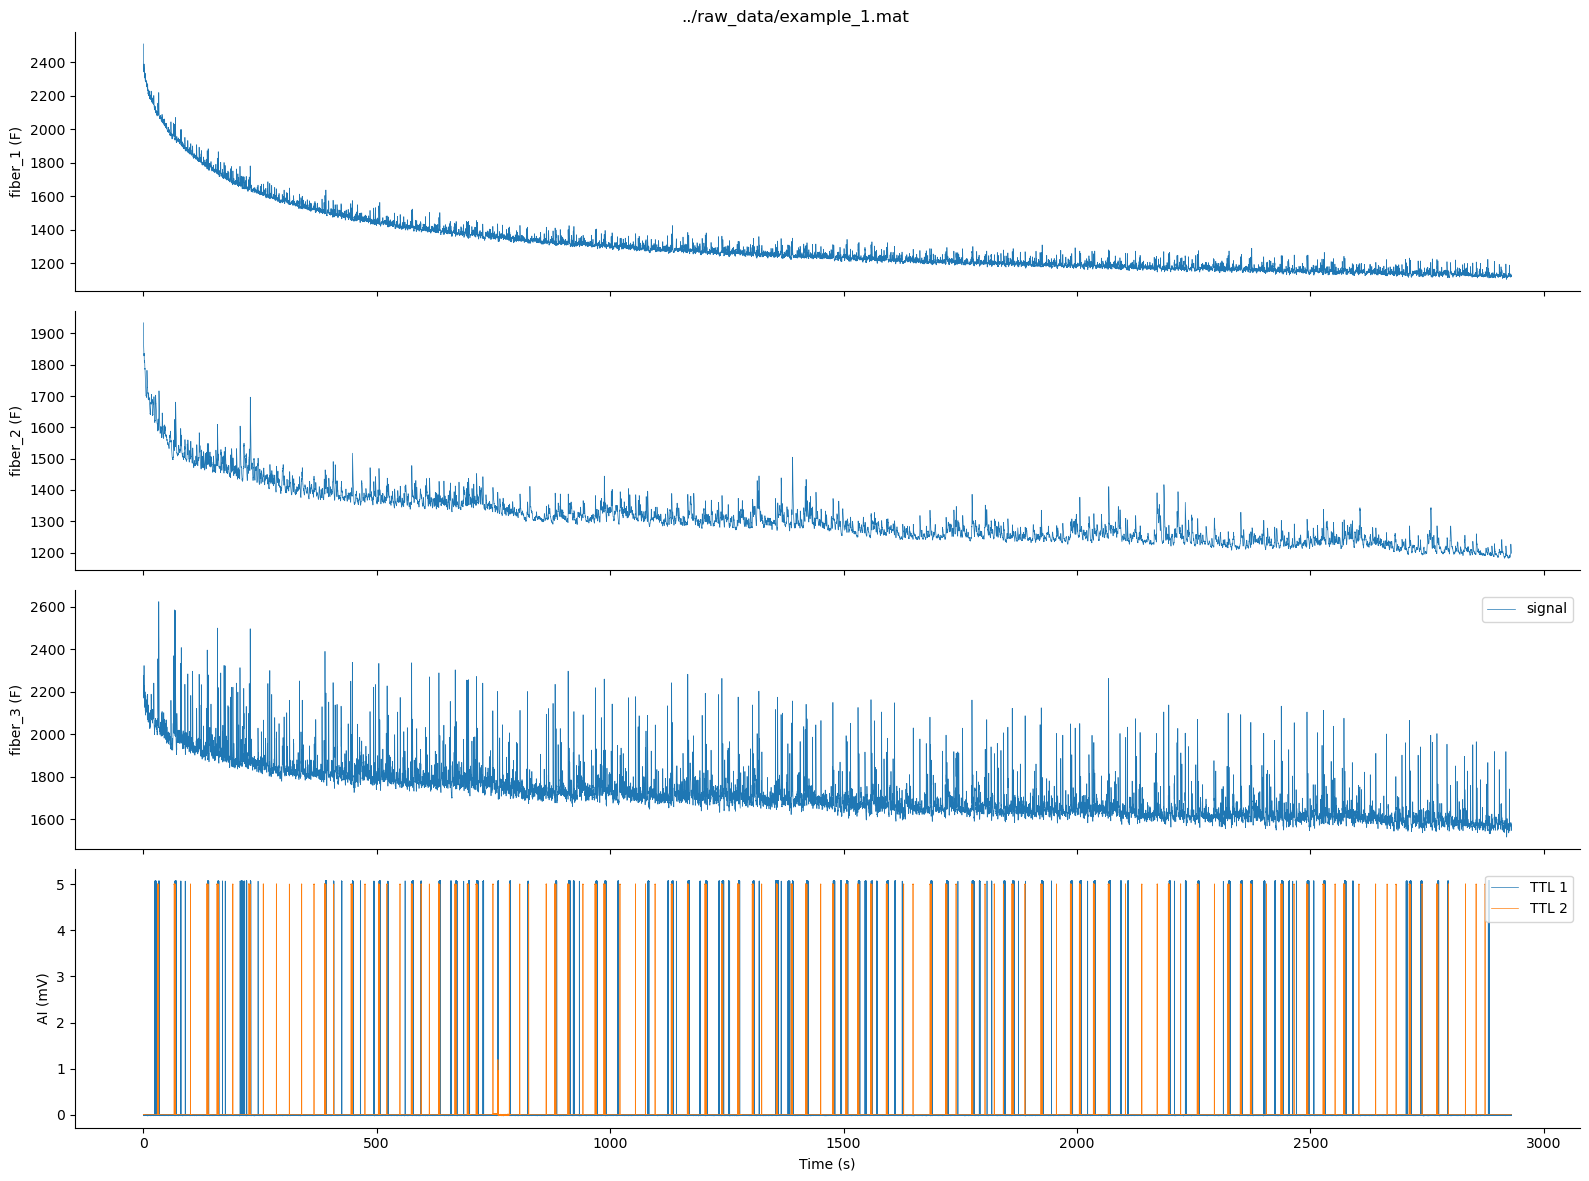

In [5]:
dataset = '../raw_data/example_1.mat'

# Load data
signal = fip.FIP_signal(filename = dataset)

# Plot the recording, use the raw_data parameter to plot either raw data (F) or normalized (dF/F) data.
signal.plot(raw_data=True);


You can browse the all the methods of the Fip_signal object [here](https://github.com/handejong/Fipster/blob/master/Fipster_python/Fipster.py) or you can use 'dir' and 'help' as in the cell below. Methods that generally come in handy are:
- *quick_peri and peri_event:*    to make peri-event plots, see below
- *derive_timestamps:*            to derive timestamps from raw logAI input, see below
- *plot:*                         to plot the signal, see above
- *get_data:*                     to get the normalized data, if you don't want to use FIP_signal but want to write your own code from scratch
- *sync_time:*                    very useful method to align the timeline of the FIP_signal object with some external timeline, for instance if you record behavior somewhere else.
- *fix_signal_switch:*            in case there are errors where the signal and reference trace are "switched"

There are also some properties that are interesting
- *settings:*                     contains a dict with settings, the most important one is "fit ref" which controls how the 405nm trace is fit to the 470nm trace.
- *filter:*                       here you can put a butter filter from scipy which will be applied to all signals
- *smooth:*                       here you can set a # of datapoints over which the data should be smoothed (not recommended)



Applying provided filter to signal
Applying provided filter to signal
Applying provided filter to signal


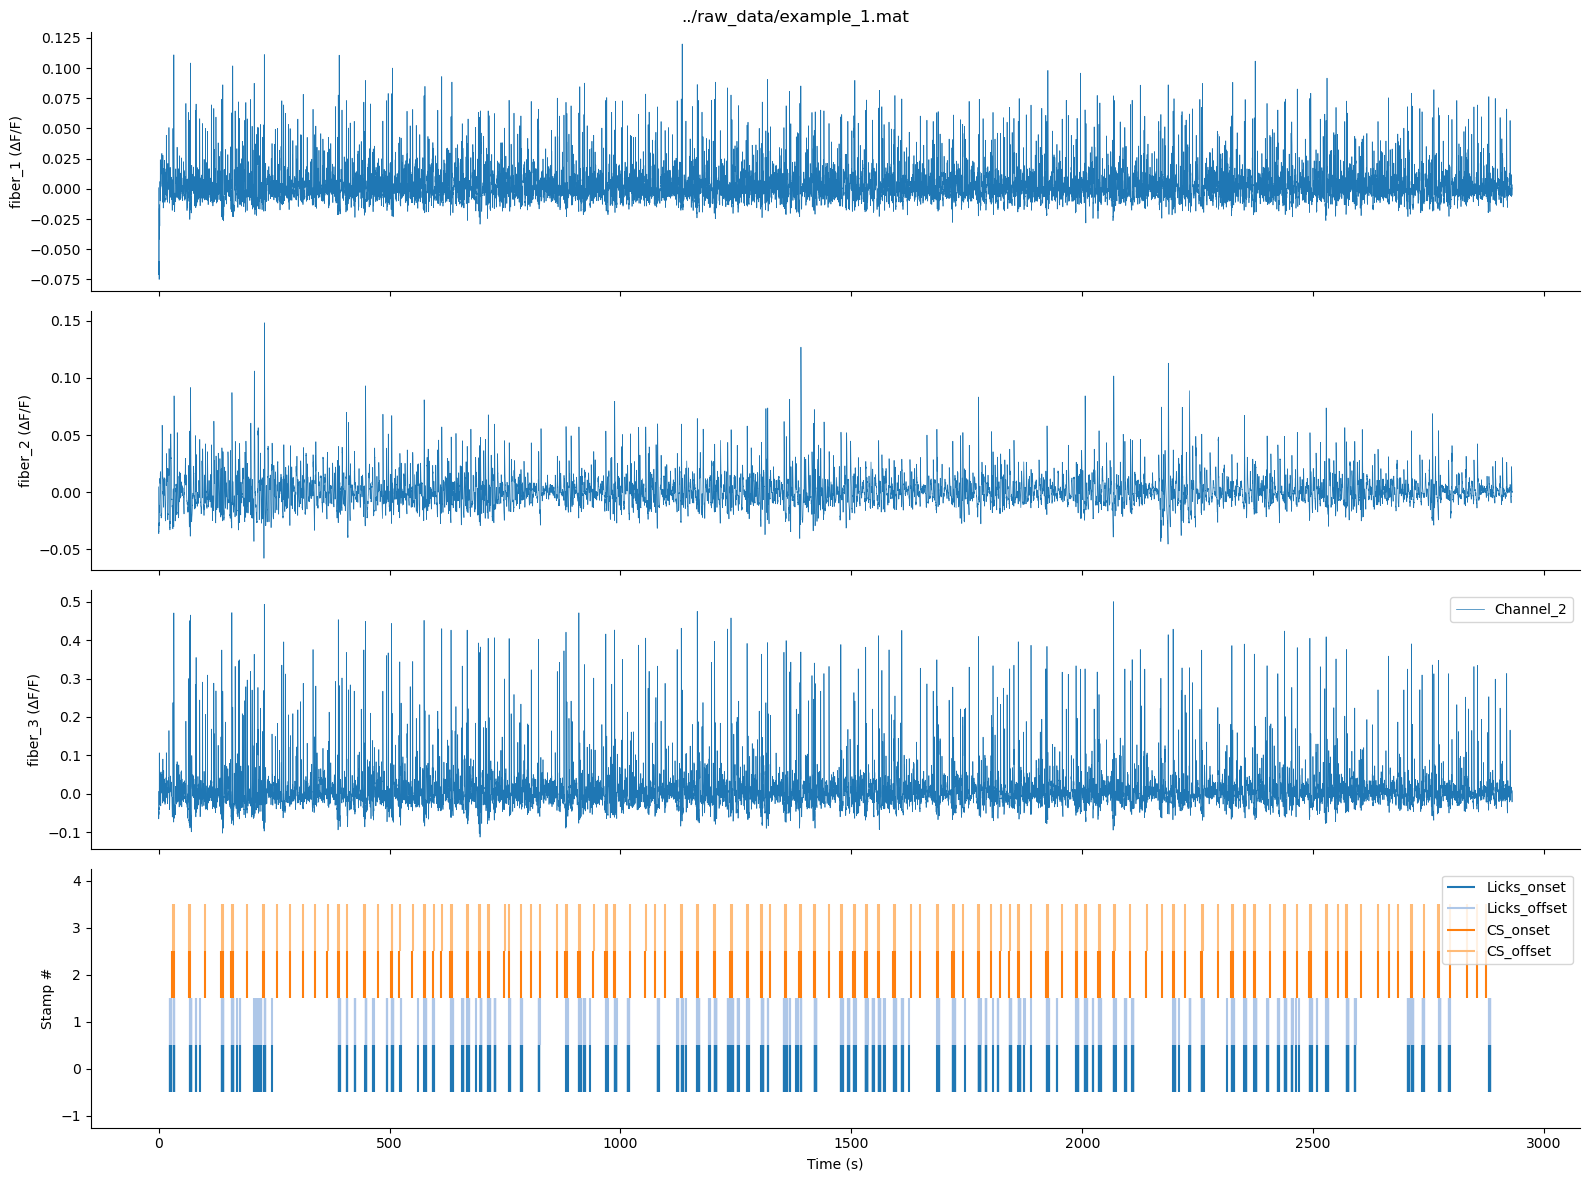

In [25]:
# Applying a 0.1Hz highpass filter to the signal in order to de-trend it
# Do not run this cell, or re-run the cell above if you don't want to apply the filter (which we generally don't)

# Make the filter and include it in FIP_signal
from scipy.signal import butter
cuttoff = 0.1 # Hz (low pass)
nquist_f = 0.5 * signal.framerate
signal.filter = butter(3, cuttoff/nquist_f, btype='high', analog=False, output='ba')

# Plot the data
signal.plot(raw_data=False);

# (In the same way, we can apply a low pass filter to the signal to remove high-frequency noise.)

### Deriving timestamps and making peri-event plots
Use the method "derive_timestamps" to derive timestamps from the logAI trace. Note the examples below. Note that by default the timestamps are also imported into the FIP_signal object. Specifically, the "timestamps" property contains a dict with all included timestamps. You can easily put externally obtained timestamps in there as well.

In [9]:
# Convert the TTL signal (bottom panel) to timestamps

# Include all TTL stamps from channel 1
licks = signal.derive_timestamps('TTL 1',
    names=['Licks'])

# From channel 2 include only the TTL stamps that are between 0.9 and 1.1 seconds long
CS = signal.derive_timestamps('TTL 2', 
    min_length=0.9, 
    max_length=1.1,
    names=['CS'])

# Note: if you use signal.plot now, it will plot the timestamps instead of the logAI!

Importing 989 stamps, named: Licks
Importing 153 stamps, named: CS


To make peri-event plots, there are two included methods:
- quick_peri
- peri_event

Quick peri is most usefull for a quick z-score normalized peri-event set. Peri_event has a bit more flexibility.

Applying provided filter to signal
Applying provided filter to signal
Applying provided filter to signal


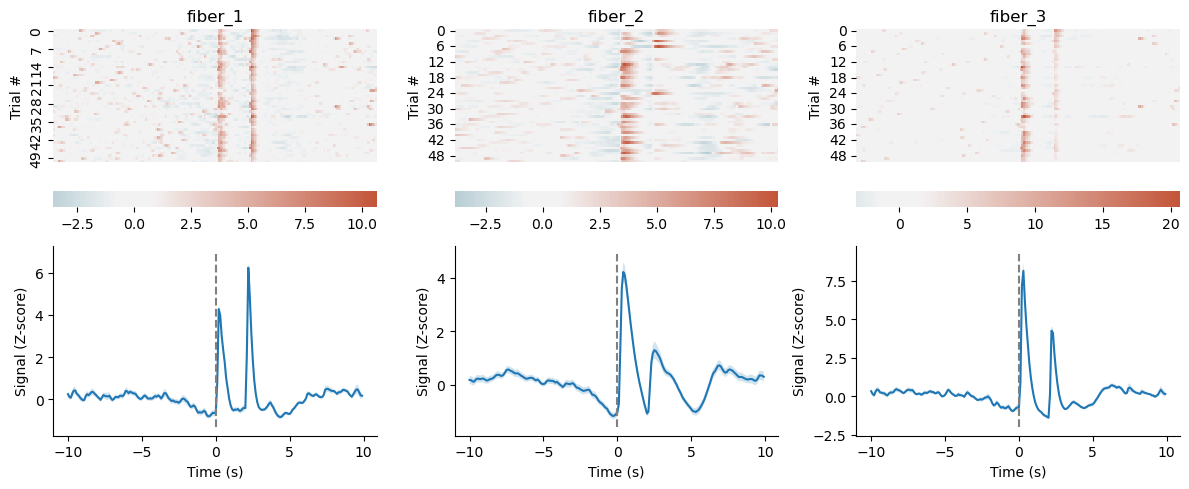

In [26]:
# Make the sweeset object
stamps = CS.end
sweepset = signal.peri_event(stamps)

# Include some settings
sweepset.settings["baseline"] = [-10, 0]
sweepset.settings['baseline subtract'] = True
sweepset.settings["Z-score"] = True

sweepset.make_figure();
    

Note that there is a filtering artifact in some of these plots. You prevent this, you could just not filter the data or (better) record with a 405nm trace and use that to detrend the data.

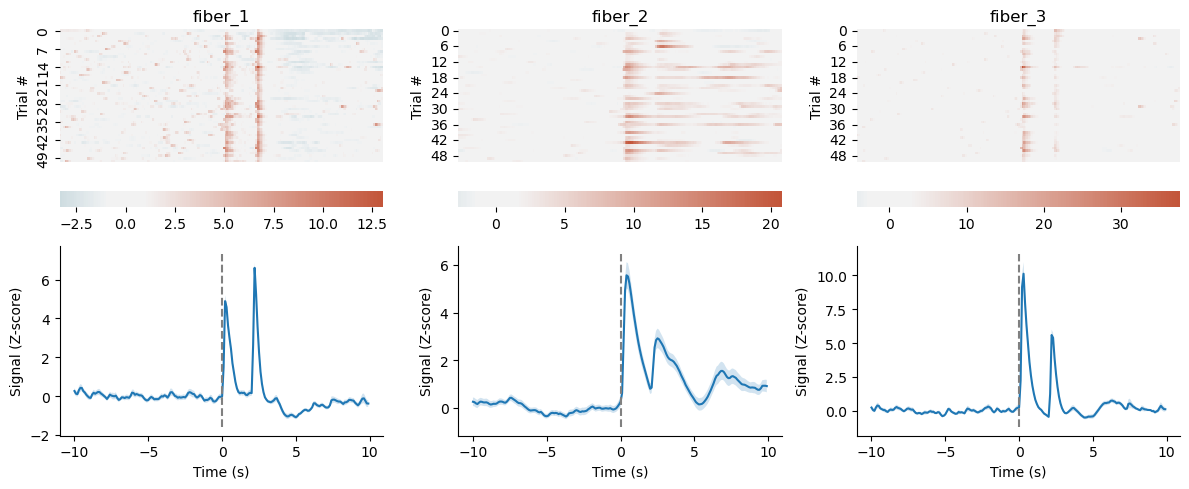

In [27]:
# Example of the same analysis but with unfiltered data (which is generally completely fine)
signal.filter = None
sweepset = signal.peri_event(stamps)
sweepset.settings["baseline"] = [-10, 0]
sweepset.settings['baseline subtract'] = True
sweepset.settings["Z-score"] = False
sweepset.settings["Z-score"] = True

sweepset.make_figure();

# Dealing with these pesky "signal switch" artifacts.
These occur because the camera missed one frame and consequently started collecting reference (405nm) and signal (470nm) frames in the wrong dataset.

Loading: ../raw_data/example_2.mat
Loading: ../raw_data/example_2_logAI.csv
Sampling interval is: 5.0ms
...resampled
 
RECORDING NOTES: These notes are saved after recording.
 


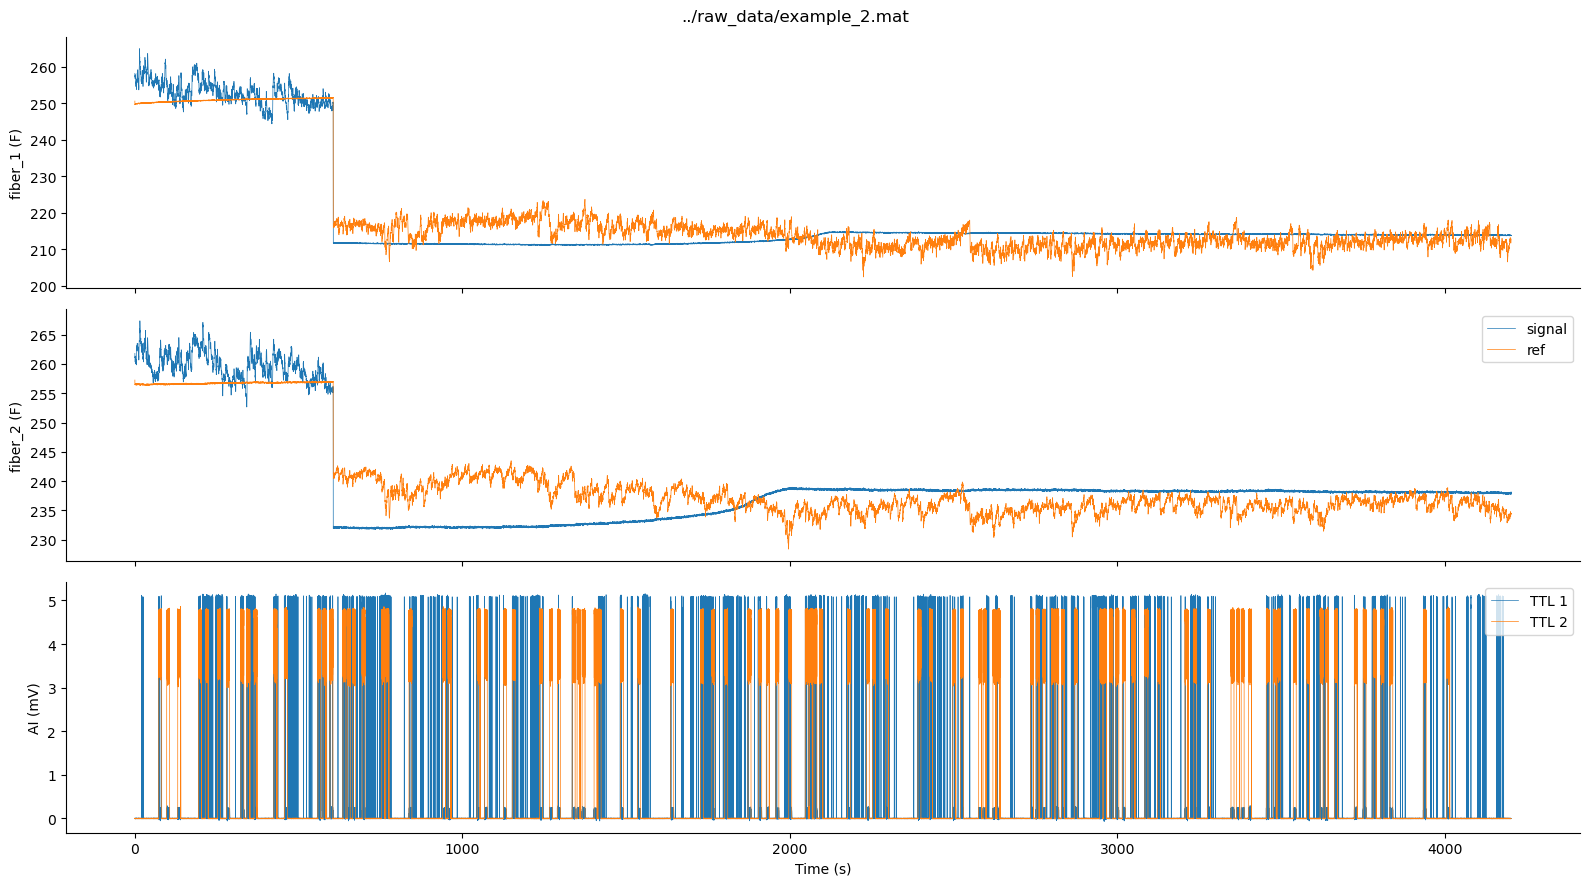

In [28]:
# Loading the example data
dataset = '../raw_data/example_2.mat'

# Load data
signal = fip.FIP_signal(filename = dataset)

# Plot the recording, use the raw_data parameter to plot either raw data (F) or normalized (dF/F) data.
signal.plot(raw_data=True);


To deal with this we use the methods:
- find_signal_switch (will help you find the index of where the switch occurs)
- fix_signal_switch (will insert the missing frame and fix the artifact)

NOTE: You can pass any index (even one you manually find) to "fix_signal_switch", but if you don't pass any, it will just run "find_signal_switch" by itself to find the index.

Found signal switch at index [6056, 6056] (size: [13259194.328061614, 5674839.588418286])
Switched signal and reference at index [6056, 6056] (time: 605.625)


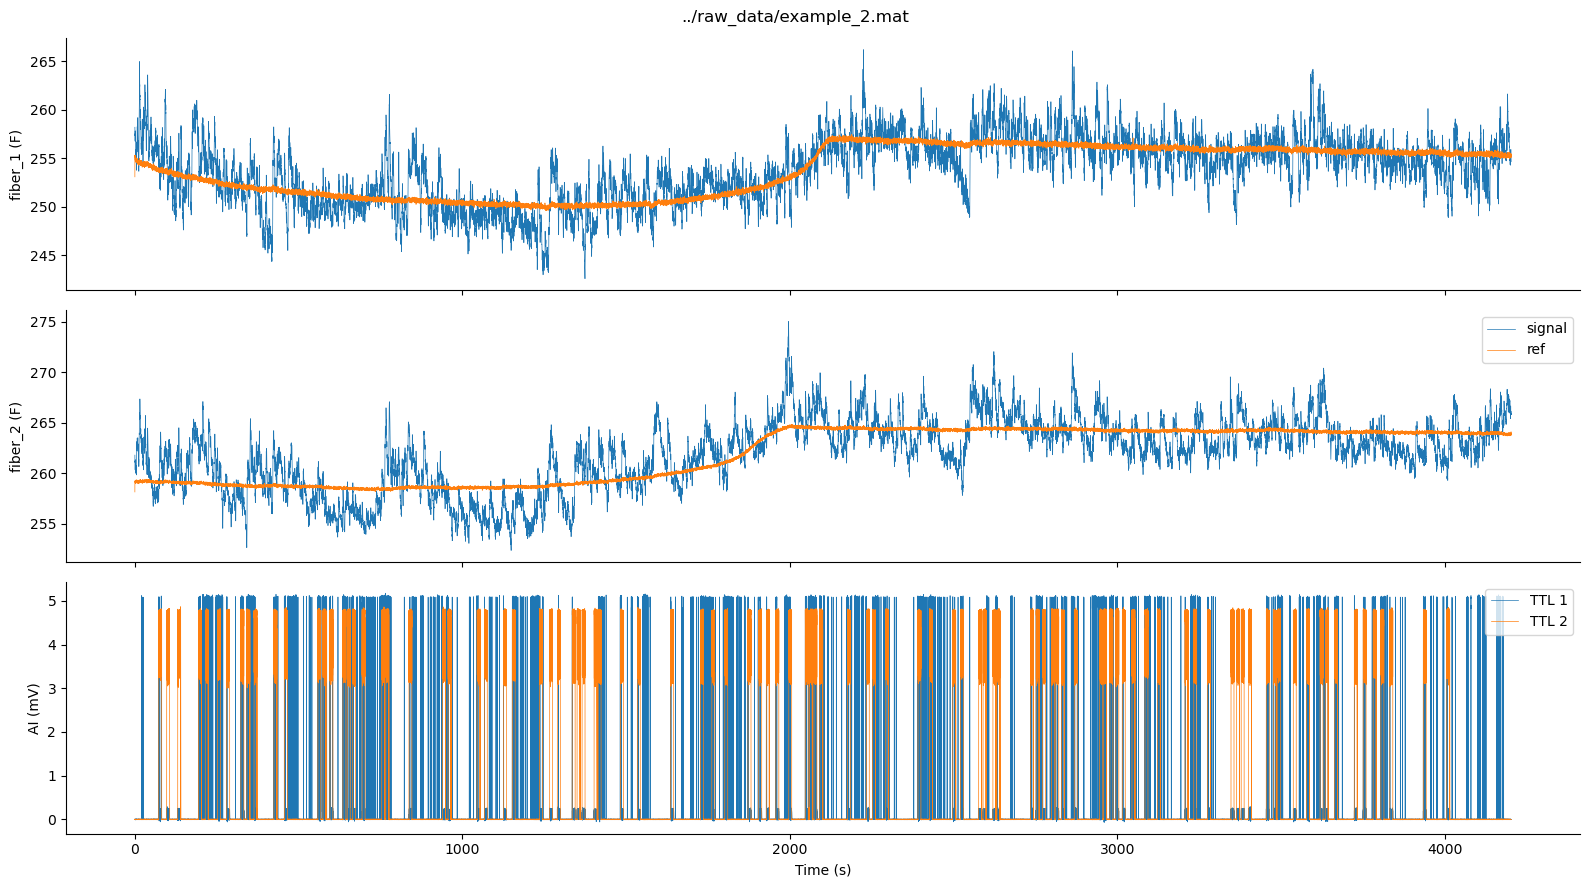

In [30]:
signal.fix_signal_switch()
signal.plot(raw_data=True);